In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt

import os, re, glob

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Define functions

In [2]:
def data_processor(infile,timepoint,ref_protein="WT"):
    """
    Load data, find center points, extract a specific time point, and
    calculate difference relative to a reference protein.
    """
    
    # read file
    df = pd.read_csv(infile)
    
    # Get peptide center position
    step = (df["End"] - df["Start"])/2
    df["pep_center"] = df["Start"] + step
    

    ref = df.loc[df["Protein State"] == ref_protein]
    ref = ref[ref["Deut Time (sec)"] == timepoint]
    ref = ref.reset_index(drop=True)
    
    ref.loc["", "Stddev"] = 0
    ref["%D_stdev"] = 100*ref["Stddev"]/ref["maxD"]
    ref["%D_stderr"] = ref["%D_stdev"]/(ref["#Pts"] - 1)  

    proteins = np.unique(df["Protein State"])
    
    dfs = {}
    
    for i in range(len(proteins)):
        
        d = df.loc[df["Protein State"] == proteins[i]]
        d = d.loc[d["Deut Time (sec)"] == timepoint]
        d = d.reset_index(drop=True)
            
        d["%D_stdev"] = 100*d["Stddev"]/d["maxD"]
        d["%D_stderr"] = d["%D_stdev"]/(d["#Pts"] - 1)
        
        d["diff"] = d["%D"] - ref["%D"]
        d["diff_err"] = np.sqrt((ref["%D_stdev"])**2 + (d["%D_stdev"])**2)

        dfs[proteins[i]] = d
        
    return dfs

def uptake_plotter(dfs,colors=None,proteins=None,fig=None,ax=None):
    """
    Create a plot of all of %deuterium uptake versus peptide position.
    """
        
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    
    if colors is None:
        colors = ["black","red","pink","purple"]
    
    if proteins is None:
        proteins = list(dfs.keys())
    
    for i in range(len(proteins)):
        
        d = dfs[proteins[i]]

        # Draw peptide centers with errors
        ax.errorbar(d["pep_center"], d["%D"], yerr=d["%D_stdev"],fmt="o",
                    markersize=10,mfc="none",mec=colors[i],color=colors[i],
                    capsize=3,zorder=20)
  
        # Draw line through peptide centers, skipping long gaps
        x = np.array(d["pep_center"])
        y = np.array(d["%D"])
        order = np.argsort(x)
        x = x[order]
        y = y[order]
        for j in range(len(x)-1):
            if x[j+1] - x[j] < 2:
                ax.plot(x[j:j+2],y[j:j+2],"-",color=colors[i],lw=3,zorder=20)
        
        # Draw peptide coverage as gray lines
        for j in range(len(d)):
            row = d.iloc[j]
            ax.plot([row["Start"],row["End"]],[row["%D"],row["%D"]],color="gray",lw=2) 
        
        # Set axes limits and labels
        ax.set_ylim(0,100)

        ax.set_ylabel("%deuterium Uptake")
            
    return fig, ax

def uptake_diff_plotter(dfs,colors=None,proteins=None,fig=None,ax=None):
    """
    Create a plot of all of the difference in %deuterium uptake relative to 
    refeence versus peptide position.
    """
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    
    if colors is None:
        colors = ["black","red","pink","purple"]
    
    if proteins is None:
        proteins = list(dfs.keys())
    

    for i in range(len(proteins)):
        
        d = dfs[proteins[i]]

        # Draw peptide centers with errors
        ax.errorbar(d["pep_center"], d["diff"], yerr=d["diff_err"],fmt="o",
                    markersize=10,mfc="none",mec=colors[i],color=colors[i],
                    capsize=3,zorder=20)
  
        # Draw line through peptide centers, skipping long gaps
        x = np.array(d["pep_center"])
        y = np.array(d["diff"])
        order = np.argsort(x)
        x = x[order]
        y = y[order]
        for j in range(len(x)-1):
            if x[j+1] - x[j] < 2:
                ax.plot(x[j:j+2],y[j:j+2],"-",color=colors[i],lw=3,zorder=20)
        
        # Draw peptide coverage as gray lines
        for j in range(len(d)):
            row = d.iloc[j]
            ax.plot([row["Start"],row["End"]],[row["diff"],row["diff"]],color="gray",lw=2) 
        
        # Set axes limits and labels
        ax.set_ylim(-70,70)

        ax.set_ylabel("change in %deuterium uptake")
            
            
    ax.plot((0,114),(0,0),"--",color="gray")
    
    return fig, ax

def hdx_values_on_structure(df,out_dir,write_diff=False,glob_pattern="nmr-structures/*.pdb"):
    """
    Load hdx values into b-factor colums for structures in the NMR ensemble.
    """

    def _process_pdb(pdb_file,data_vector):
        """
        Process a pdb file, adding hdx values to b-factor column.
        """

        out = []
        with open(pdb_file) as f:
            for line in f:
                if line.startswith("ATOM"):
                    idx = int(line[22:26].strip())-1

                    try:
                        b = data_vector[idx]
                    except IndexError:
                        b = 0

                    if np.isnan(b):
                        b = 0

                    out.append(f"{line[:60]}{b:6.2f}{line[66:]}")

        return "".join(out)
    
    if not write_diff:
        column = "%D"
    else:
        column = "diff"
    
    results = {}
    for key in df:

        this_df = df[key]

        counts = np.zeros(114,dtype=np.float)
        diff = np.zeros(114,dtype=np.float)
        for i in range(len(this_df)):
            row = this_df.iloc[i]

            d = row[column]

            if np.isnan(d):
                continue

            s = int(row["Start"]) - 1
            e = int(row["End"]) - 1 

            counts[s:e] += 1
            diff[s:e] += d

        key = this_df.iloc[0]["Protein State"]
        
        results[key] = diff/counts    

    pdb_list = glob.glob(glob_pattern)

    for key in results.keys():
        for p in pdb_list:

            out = _process_pdb(p,results[key])

            root = os.path.split(p)[-1]

            sanitized_key = re.sub("\/","-",key)

            f = open(os.path.join(out_dir,f"{sanitized_key}_{root}"),"w")
            f.write(out)
            f.close()

### Load data

In [3]:
# Load one hour time point, using wt, M63F, and F37L as reference protein
dfs_wt_ref = data_processor("table_sxx_deterium-uptake-data.csv",3600)
dfs_m63f_ref = data_processor("table_sxx_deterium-uptake-data.csv",3600,ref_protein="M63F")
dfs_f37l_ref = data_processor("table_sxx_deterium-uptake-data.csv",3600,ref_protein="F37L")

### Fig 4A,C: Plot % versus residue for each protein, relative to wildtype

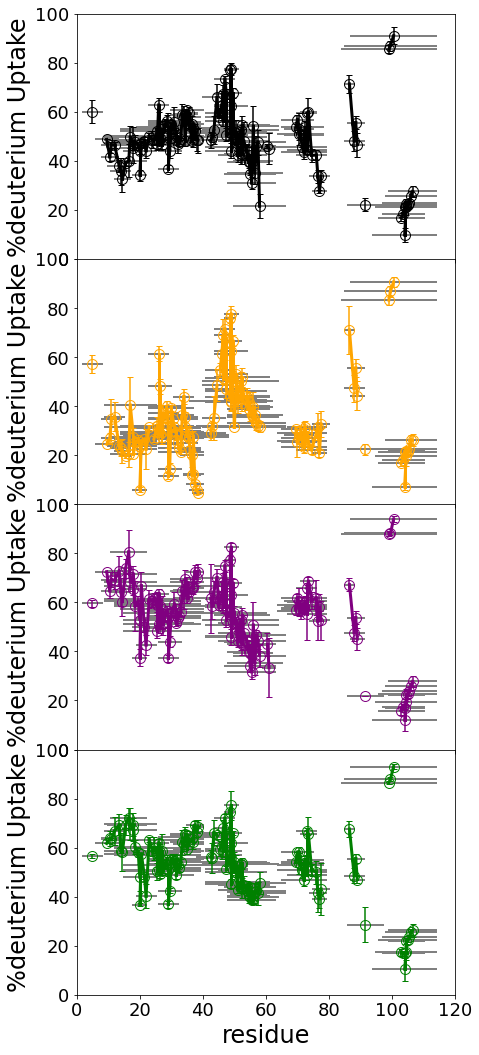

In [4]:
colors = ["black","orange","purple","green"]
fig, ax = plt.subplots(4,1,figsize=(7,15),sharex=True)
for i, protein in enumerate(["WT","M63F","F37L","F37L/M63F"]):
    fig, ax[i] = uptake_plotter(dfs_wt_ref,proteins=[protein],colors=[colors[i]],
                                fig=fig,ax=ax[i])

ax[-1].set_xlabel("residue")
ax[-1].set_xlim((0,120))
plt.tight_layout()
fig.subplots_adjust(hspace=0)

fig.savefig("figure_4ac_main.pdf")

plt.show()

### Fig 4A,C: histograms of %deuterium uptake

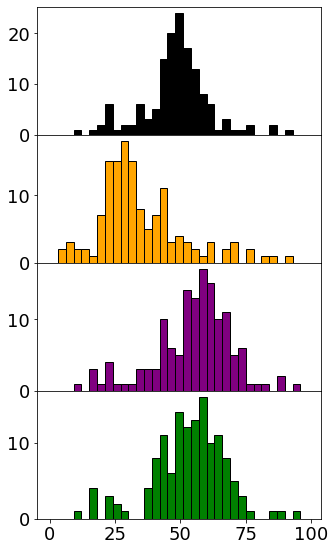

In [5]:
colors = ["black","orange","purple","green"]

fig, ax = plt.subplots(4,1,figsize=(5,8),sharex=True)
for i, protein in enumerate(["WT","M63F","F37L","F37L/M63F"]):

    x = dfs_wt_ref[protein]["%D"]
    counts, edges = np.histogram(x,bins=np.arange(0,100,3))
    ax[i].bar((edges[1:] + edges[:-1])/2,counts,width=3,color=colors[i],edgecolor="black")
    
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.savefig("figure_4ac_hist.pdf")
plt.show()

### Figure 4bd: map values to structure

In [6]:
hdx_values_on_structure(dfs_wt_ref,"figure_4bd_structures/")

/var/folders/p_/hcs03cdj48nbsvw72d92tr040000gn/T/ipykernel_86396/854965281.py:194: RuntimeWarning: invalid value encountered in true_divide
  results[key] = diff/counts


### Figure 4E: Differences in %deuterium uptake relative to hS100A9 for each protein

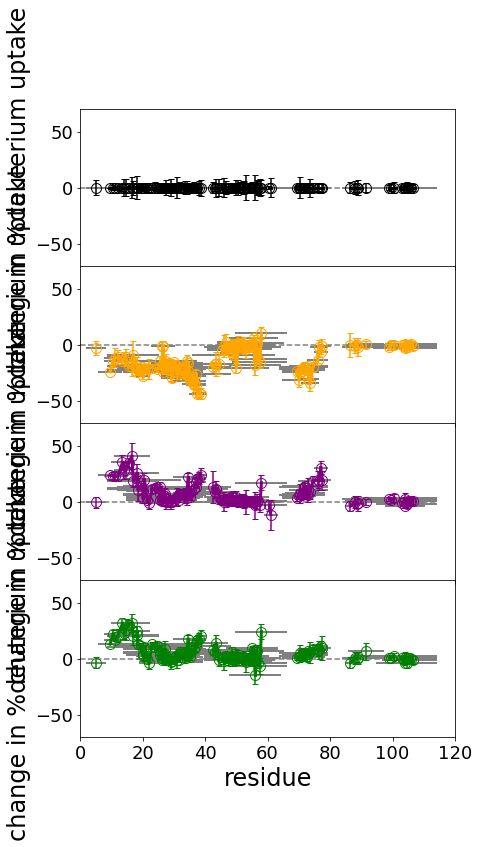

In [7]:


colors = ["black","orange","purple","green"]
fig, ax = plt.subplots(4,1,figsize=(7,10),sharex=True)
for i, protein in enumerate(["WT","M63F","F37L","F37L/M63F"]):
    fig, ax[i] = uptake_diff_plotter(dfs_wt_ref,proteins=[protein],colors=[colors[i]],
                                     fig=fig,ax=ax[i])

ax[-1].set_xlabel("residue")
ax[-1].set_xlim((0,120))
plt.tight_layout()
fig.subplots_adjust(hspace=0)

fig.savefig("figure_4e_main.pdf")

plt.show()



### Figure 4E: Histograms of differences in %deuterium uptake relative to hS100A9 for each protein

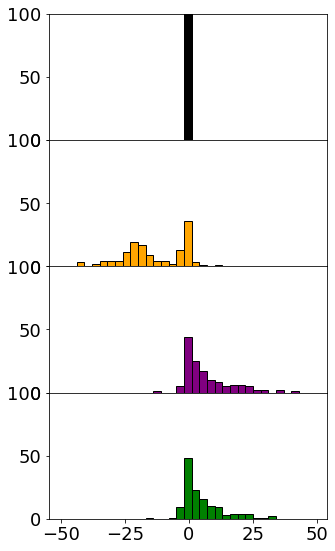

In [8]:
colors = ["black","orange","purple","green"]

fig, ax = plt.subplots(4,1,figsize=(5,8),sharex=True)
for i, protein in enumerate(["WT","M63F","F37L","F37L/M63F"]):

    x = dfs_wt_ref[protein]["diff"] #["%D"]
    counts, edges = np.histogram(x,bins=np.arange(-50,50,3))
    ax[i].bar((edges[1:] + edges[:-1])/2,counts,width=3,color=colors[i],edgecolor="black")
    ax[i].set_ylim(0,100)
plt.tight_layout()
fig.subplots_adjust(hspace=0)

fig.savefig("figure_4e_hist.pdf")
plt.show()

### Figure 4F: map m63f-wt hdx values to structure

In [9]:
hdx_values_on_structure(dfs_m63f_ref,"figure_4f_structures/")

/var/folders/p_/hcs03cdj48nbsvw72d92tr040000gn/T/ipykernel_86396/854965281.py:194: RuntimeWarning: invalid value encountered in true_divide
  results[key] = diff/counts


### Figure 5C: Differences in %deuterium uptake relative to hS100A9/F37L for each protein

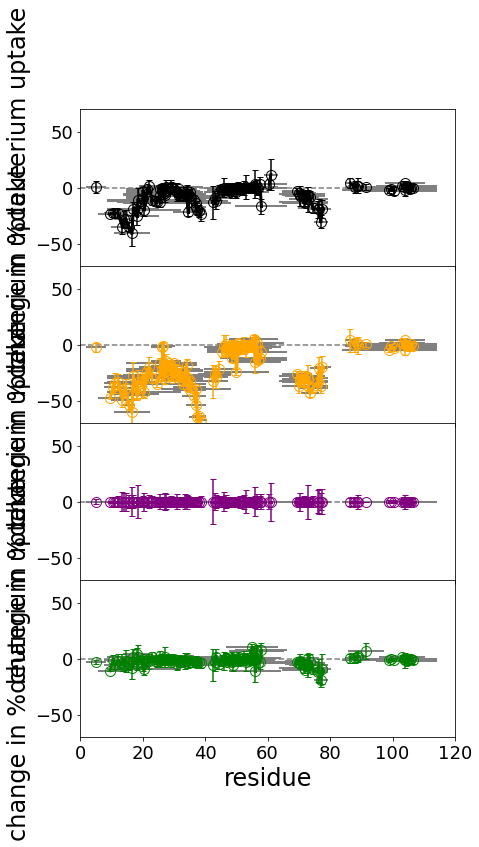

In [10]:
colors = ["black","orange","purple","green"]
fig, ax = plt.subplots(4,1,figsize=(7,10),sharex=True)
for i, protein in enumerate(["WT","M63F","F37L","F37L/M63F"]):
    fig, ax[i] = uptake_diff_plotter(dfs_f37l_ref,proteins=[protein],colors=[colors[i]],
                                     fig=fig,ax=ax[i])

ax[-1].set_xlabel("residue")
ax[-1].set_xlim((0,120))
plt.tight_layout()
fig.subplots_adjust(hspace=0)

fig.savefig("figure_5c_main.pdf")

plt.show()

### Figure 5C: Histograms of differences in %deuterium uptake relative to hS100A9/F37L for each protein

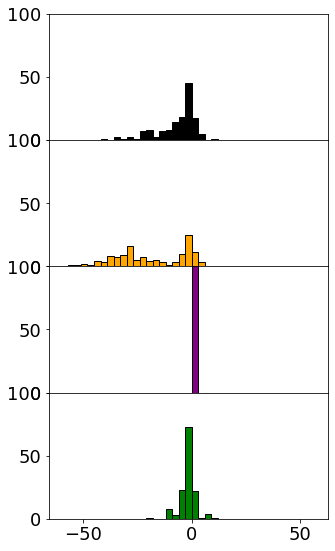

In [11]:
colors = ["black","orange","purple","green"]

fig, ax = plt.subplots(4,1,figsize=(5,8),sharex=True)
for i, protein in enumerate(["WT","M63F","F37L","F37L/M63F"]):

    x = dfs_f37l_ref[protein]["diff"] 
    counts, edges = np.histogram(x,bins=np.arange(-60,60,3))
    ax[i].bar((edges[1:] + edges[:-1])/2,counts,width=3,color=colors[i],edgecolor="black")
    ax[i].set_ylim(0,100)
plt.tight_layout()
fig.subplots_adjust(hspace=0)

fig.savefig("figure_5c_hist.pdf")

plt.show()

### Fig 5D: Map HDX for variants - F37L to structures

    

In [12]:
hdx_values_on_structure(dfs_f37l_ref,"figure_5d_structures/")

/var/folders/p_/hcs03cdj48nbsvw72d92tr040000gn/T/ipykernel_86396/854965281.py:194: RuntimeWarning: invalid value encountered in true_divide
  results[key] = diff/counts
